In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

#Ordinary Least Squared function
def ols(x, y, z, degree = 5):
    #x: vector of size(n, 1)
    #y: vector of size(n,1)
    # z: vector of size(n,1)
    xyb_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    xyb = poly.fit_transform(xyb_)
    beta = np.linalg.inv(xyb.T.dot(xyb)).dot(xyb.T).dot(z)

    return beta

In [2]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

"""
    Linear regression using the Ridge method
"""

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)



    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta


In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import numpy as np

def Lasso(x, y, z, degree=5, a=1e-06):

    X = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = linear_model.Lasso(alpha=a, max_iter=5000, fit_intercept=False)
    clf.fit(X_, z)
    beta = clf.coef_

    return beta

In [4]:
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt

def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))
        #print('Round: ', i)

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance

In [5]:
def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    meanValue = np.mean(zReal)
    numerator = np.sum((zReal - zPredicted)**2)
    denominator = np.sum((zReal - meanValue)**2)
    result = 1 - (numerator/denominator)
    return result

In [6]:
def betaCI_OLS(z_real, beta, X):
    """
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    ci_minus = beta - 1.645*np.sqrt(var_beta/N)
    ci_plus = beta + 1.645*np.sqrt(var_beta/N)

    return ci_minus, ci_plus

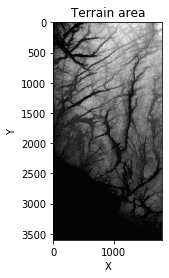

In [7]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

# Load the terrain
terrain1 = imread('SRTM_data_Norway_2.tif')
# Show the terrain
plt.figure()
plt.title('Terrain area')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

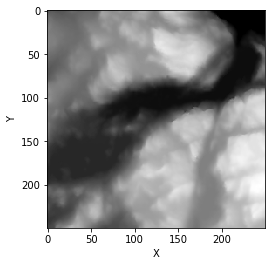

In [8]:
# Choose a smaller part of the data set
terrain = terrain1[500:750, 0:250]
# Show the terrain
plt.figure()
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('../Results/ex6/terrain_original.png')
plt.show()

In [9]:
# Make zero matrix to later fit data
num_rows, num_cols = np.shape(terrain)
num_observations = num_rows * num_cols
X = np.zeros((num_observations, 3))

In [10]:
# make a matrix with all the values from the data on the form [x y z]
index = 0
#X = X-np.mean(X)
for i in range(0, num_rows):
    for j in range(0, num_cols):
        X[index, 0] = i  # x
        X[index, 1] = j  # y
        X[index, 2] = terrain[i, j]  # z
        index += 1

In [11]:
# OLS example
# extract x, y, z
xt = X[:,0, np.newaxis]
yt = X[:,1, np.newaxis]
zt = X[:,2, np.newaxis]

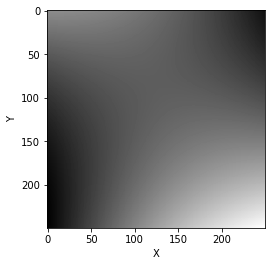

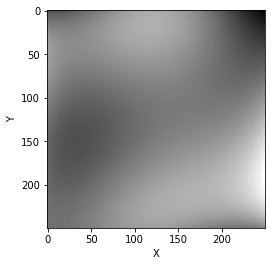

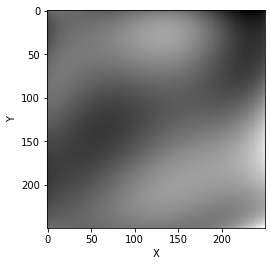

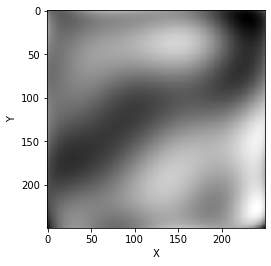

In [23]:
degree = [2, 4, 6, 8]
text_file = open("../Results/ex6/terrain_CI_ols.txt", "w")
for d in degree:
    beta = ols(xt, yt, zt, degree=d)
    
    M_ = np.c_[xt, yt]
    poly = PolynomialFeatures(d)
    M = poly.fit_transform(M_)
    z_predict = M.dot(beta)
    
    
    T = np.zeros([num_rows, num_cols])
    index = 0
    # create matrix for imshow
    for i in range(0, num_rows):
        for j in range(0, num_cols):
            T[i, j] = (z_predict[index])
            index += 1
    plt.figure()
    plt.imshow(T, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig('../Results/ex6/terrain_ols_d{}.png'.format(d))
    

    z_test = np.zeros(zt.shape[0])
    for i in range(zt.shape[0]):
        z_test[i] = zt[i][0]
    
    beta_test = np.zeros(beta.shape[0])
    for i in range(beta.shape[0]):
        beta_test[i] = zt[i][0]
        
    
    conf1, conf2 = betaCI_OLS(z_test, beta_test, M)
    #print(conf2.shape)
    for i in range(len(conf1)):
        text_file.write('Beta {0}: {1:5f} & [{2:5f}, {3:5f}] \n'.format(i, beta_test[i], conf1[i], conf2[i]))
        
text_file.close()


In [24]:
# Evaluate model with bootstrap algorithm
text_file = open("../Results/ex6/terrain_mse_ols.txt", "w")
MSE, R2, bias, variance = bootstrap(xt, yt, zt, p_degree=8, method='OLS', n_bootstrap=100)
text_file.write('MSE: {0:5f} & R2: {1:5f} & bias: {2:5f} & var: {3:5f}'.format(MSE, R2, bias, variance))
text_file.close()

C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


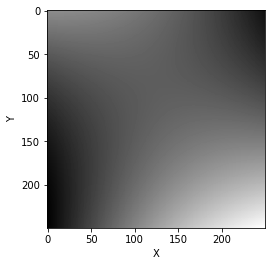

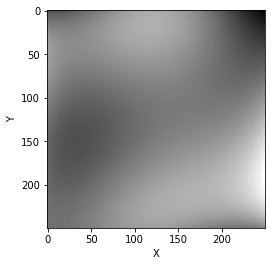

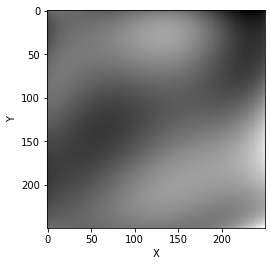

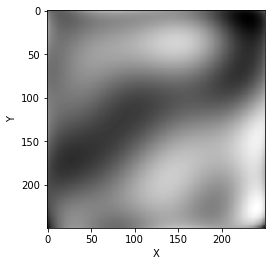

In [12]:
degree = [2, 4, 6, 8]
text_file = open("../Results/ex6/terrain_CI_ridge.txt", "w")
for d in degree:
    beta = RidgeRegression(xt, yt, zt, degree=d)
    
    M_ = np.c_[xt, yt]
    poly = PolynomialFeatures(d)
    M = poly.fit_transform(M_)
    z_predict = M.dot(beta)
    
    
    T = np.zeros([num_rows, num_cols])
    index = 0
    # create matrix for imshow
    for i in range(0, num_rows):
        for j in range(0, num_cols):
            T[i, j] = (z_predict[index])
            index += 1
    plt.figure()
    plt.imshow(T, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig('../Results/ex6/terrain_ridge_d{}.png'.format(d))
    

    z_test = np.zeros(zt.shape[0])
    for i in range(zt.shape[0]):
        z_test[i] = zt[i][0]
    
    beta_test = np.zeros(beta.shape[0])
    for i in range(beta.shape[0]):
        beta_test[i] = zt[i][0]
        
    
    conf1, conf2 = betaCI_OLS(z_test, beta_test, M)
    #print(conf2.shape)
    for i in range(len(conf1)):
        text_file.write('Beta {0}: {1:5f} & [{2:5f}, {3:5f}] \n'.format(i, beta_test[i], conf1[i], conf2[i]))
    
text_file.close()

In [13]:
# Evaluate model with bootstrap algorithm
text_file = open("../Results/ex6/terrain_mse_ridge.txt", "w")
MSE, R2, bias, variance = bootstrap(xt, yt, zt, p_degree=8, method='Ridge', n_bootstrap=100)
text_file.write('MSE: {0:5f} & R2: {1:5f} & bias: {2:5f} & var: {3:5f}'.format(MSE, R2, bias, variance))
text_file.close()

C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496603027.8372803, tolerance: 952992.9078
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412028443.3986508, tolerance: 952992.9078
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409033266.44482887, tolerance: 952992.9078
  positive)


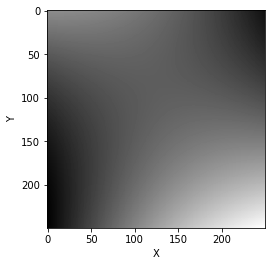

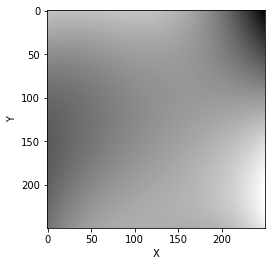

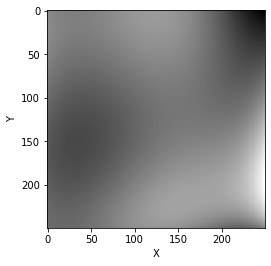

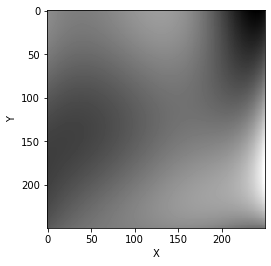

In [15]:
degree = [2, 4, 6, 8]
text_file = open("../Results/ex6/terrain_CI_lasso.txt", "w")
for d in degree:
    beta = Lasso(xt, yt, zt, degree=d)
    
    M_ = np.c_[xt, yt]
    poly = PolynomialFeatures(d)
    M = poly.fit_transform(M_)
    z_predict = M.dot(beta)
    
    
    T = np.zeros([num_rows, num_cols])
    index = 0
    # create matrix for imshow
    for i in range(0, num_rows):
        for j in range(0, num_cols):
            T[i, j] = (z_predict[index])
            index += 1
    plt.figure()
    plt.imshow(T, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig('../Results/ex6/terrain_lasso_d{}.png'.format(d))
    

    z_test = np.zeros(zt.shape[0])
    for i in range(zt.shape[0]):
        z_test[i] = zt[i][0]
    
    beta_test = np.zeros(beta.shape[0])
    for i in range(beta.shape[0]):
        beta_test[i] = zt[i][0]
        
    
    conf1, conf2 = betaCI_OLS(z_test, beta_test, M)
    #print(conf2.shape)
    for i in range(len(conf1)):
        text_file.write('Beta {0}: {1:5f} & [{2:5f}, {3:5f}] \n'.format(i, beta_test[i], conf1[i], conf2[i]))
text_file.close()

In [13]:
# Evaluate model with bootstrap algorithm
text_file = open("../Results/ex6/terrain_mse_lasso.txt", "w")
MSE_l, R2_l, bias_l, variance_l = bootstrap(xt, yt, zt, method='Lasso', p_degree=8)
text_file.write('MSE: {0:5f} & R2: {1:5f} & bias: {2:5f} & var: {3:5f}'.format(MSE_l, R2_l, bias_l, variance_l))
text_file.close()

C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325221885.17812705, tolerance: 763232.4873
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325942293.8643085, tolerance: 761

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324372072.862285, tolerance: 765361.9963
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329577030.53900266, tolerance: 764115.7322000001
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325341765.63940144, tolerance: 768154.0416
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325522020.66512

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327980927.68696624, tolerance: 764023.1499000001
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324457962.9389515, tolerance: 765871.1431
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330085664.15760714, tolerance: 765283.6599000001
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32944911

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330647228.2909124, tolerance: 760821.9731000001
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330379888.77951574, tolerance: 762114.8946
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329904649.808708, tolerance: 760710.1543
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326718458.489954

In [35]:
# Calculate beta confidence intervals
conf1, conf2 = betaCI_OLS(z_test, beta, M)
text_file = open("./Results/BetaCI_ols.txt", "w")
for i in range(len(conf1)):
    text_file.write('Beta {0}: {1:5f} & [{2:5f}, {3:5f}] \n'.format(i, beta[i], conf1[i], conf2[i]))
text_file.close()

(45, 1)

In [36]:
# Calculate beta confidence intervals
conf1, conf2 = betaCI_OLS(z_test, beta, M)
for i in range(len(conf1)):
    print('Beta {0}: {1:5f} & [{2:5f}, {3:5f}] \n'.format(i, beta[i], conf1[i], conf2[i]))


(45, 1)